In [1]:
%%capture
!pip install transformers
!pip install -q gwpy
!pip install urduhack
!pip install sentencepiece

In [2]:
# Importing the libraries needed
import re
import json
import nltk
import sys,os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from typing import FrozenSet
import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import RobertaModel, RobertaTokenizer
from transformers import AlbertTokenizer, AlbertModel
from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import urduhack
from urduhack.preprocessing import normalize_whitespace
from urduhack.preprocessing import remove_punctuation
from urduhack.preprocessing import remove_accents
from urduhack.preprocessing import replace_urls
from urduhack.preprocessing import replace_emails
from urduhack.preprocessing import replace_phone_numbers
from urduhack.preprocessing import replace_numbers
from urduhack.preprocessing import replace_currency_symbols
from urduhack import normalize
from urduhack.models.lemmatizer import lemmatizer

import logging
logging.basicConfig(level=logging.ERROR)

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d akkefa/imdb-dataset-of-50k-movie-translated-urdu-reviews

!kaggle datasets download -d chand3811/urdu-tweets

!kaggle datasets download -d adnanzaidi/urdu-stopwords

 59% 19.0M/32.3M [00:00<00:00, 88.1MB/s]
100% 32.3M/32.3M [00:00<00:00, 107MB/s] 
  0% 0.00/36.0k [00:00<?, ?B/s]
100% 36.0k/36.0k [00:00<00:00, 59.3MB/s]
  0% 0.00/867k [00:00<?, ?B/s]
100% 867k/867k [00:00<00:00, 58.2MB/s]


In [7]:
!unzip /content/urdu-tweets.zip

!unzip /content/imdb-dataset-of-50k-movie-translated-urdu-reviews.zip

!unzip /content/urdu-stopwords.zip

Archive:  /content/urdu-tweets.zip
  inflating: urdu_tweets             
Archive:  /content/imdb-dataset-of-50k-movie-translated-urdu-reviews.zip
  inflating: imdb_urdu_reviews_test.csv  
  inflating: imdb_urdu_reviews_train.csv  
Archive:  /content/urdu-stopwords.zip
  inflating: UrduStop_words list version 1.pdf  
  inflating: UrduStop_words_others.txt  
  inflating: UrduStop_words_others2.txt  
  inflating: UrduStop_words_others3.txt  
  inflating: UrduStop_words_others4.txt  


In [8]:
data_imdb_train = pd.read_csv('/content/imdb_urdu_reviews_train.csv')
data_imdb_test = pd.read_csv('/content/imdb_urdu_reviews_test.csv')
data_tweet_kaggle = pd.read_csv('/content/urdu_tweets.csv')
data_tweet_github = pd.read_html('https://github.com/MuhammadYaseenKhan/Urdu-Sentiment-Corpus/blob/master/urdu-sentiment-corpus-v1.tsv')

In [9]:
data_tweet_kaggle['sentiment'].replace({'N':'negative','P':'positive'}, inplace=True)

In [10]:
data_tweet_github=data_tweet_github[0]
data_tweet_github =data_tweet_github.drop(columns=0)

In [11]:
data_tweet_github[1].replace({' P$':'\tP',' N': '\tN',' O': '\tO'},
                             inplace=True, regex=True)

data_tweet_github[1].replace({'\t\t': '\t'},
                             inplace=True, regex=True)

data_tweet_github[['Tweet','Class']] = data_tweet_github[1].str.split("\t",expand=True)

In [12]:
data_tweet_github.drop(columns=1,inplace=True)
data_tweet_github = data_tweet_github[data_tweet_github.Class != 'O'] 
data_tweet_github['Class'].replace({'N':'negative','P':'positive'}, inplace=True)

In [13]:
frames = [data_imdb_train, data_imdb_test, data_tweet_kaggle.rename(columns={'tweets':'review'}),
          data_tweet_github.rename(columns={'Tweet':'review','Class':'sentiment'})]
data = pd.concat(frames,axis=0, ignore_index=True)

In [13]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

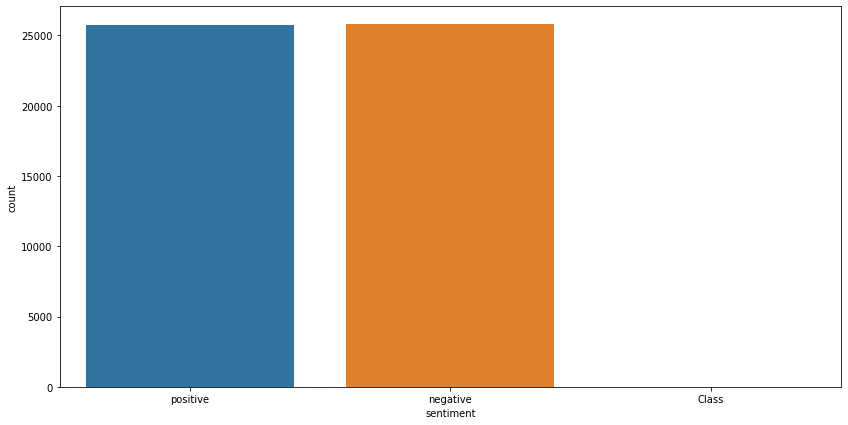

In [9]:
plt.figure(figsize=(14, 7))
sns.countplot(data.sentiment)
plt.show()

In [14]:
# Function to clean data
def preprocess_txt(x):
    x = normalize_whitespace(x)
    x = remove_punctuation(x)
    x = remove_accents(x)
    x = replace_urls(x)
    x = replace_emails(x)
    x = replace_phone_numbers(x)
    x = replace_numbers(x)
    x = replace_currency_symbols(x)
    return x

In [15]:
data["clean_data"] = list(map(preprocess_txt, data["review"]))
data.head()

,review,sentiment,clean_data
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,میں نے اسے کی دہائی کے وسط میں ایک کیبل گائیڈ...
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,چونکہ میں نے کی دہائی میں انسپکٹر گیجٹ کارٹون...
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...


In [16]:
my_file = open("/content/UrduStop_words_others4.txt", "r")
stop_word_list = my_file. read().replace('\n', '')

In [17]:
#stop word Removing
# Urdu Language Stop words list
STOP_WORDS: FrozenSet[str] = frozenset(stop_word_list.split())


In [18]:
def remove_stopwords(text):
    return " ".join(word for word in text.split() if word not in STOP_WORDS)

data["clean_data"] = list(map(remove_stopwords, data["clean_data"]))

In [19]:
def count_words(x):
    x = str(x)
    x = x.split()
    return len(x)

data["no_of_words"] = data["clean_data"].apply(count_words)
data.head()

,review,sentiment,clean_data,no_of_words
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,دہائی وسط کیبل گائیڈ اسکائینجر ہنٹ پہلو اپیل ع...,100
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,دہائی انسپکٹر گیجٹ کارٹون پسند فلم دیکھنے پیسہ...,26
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,157
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی ٹم تھا...,62
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,180


In [20]:
data.no_of_words.mean()

113.61587770245333

In [21]:
def remove_outliers():
    data["no_of_words"] = data["clean_data"].apply(count_words)
    small_str_index = data[((data.no_of_words <= 3) | (data["no_of_words"] >=512))].index
    data.drop(small_str_index, axis=0, inplace=True)
    print(f"Removed {len(small_str_index)} outliers")
    return

remove_outliers()
data

Removed 281 outliers


,review,sentiment,clean_data,no_of_words
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,دہائی وسط کیبل گائیڈ اسکائینجر ہنٹ پہلو اپیل ع...,100
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,دہائی انسپکٹر گیجٹ کارٹون پسند فلم دیکھنے پیسہ...,26
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,157
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی ٹم تھا...,62
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,180
...,...,...,...,...
51476,اُس آدمی نے اِس سالار کو کافی معقول ٹپ دی ہے ۔,positive,آدمی سالار کافی معقول ٹپ,5
51477,چچا غالب کی روح سے معذرت کے ساتھہم نے مانا کہ ...,positive,چچا غالب روح معذرت ساتھہم مانا ڈیزلمفت ہاتھ برا,9
51478,واہ جناب واہ! اچھی رہی۔ جناب خود کو فرشتہ سمجو...,positive,اچھی فرشتہ سمجوں انسان,4
51479,اسلام آباد :پی اے ٹی کا دھرنا ختم، صفائی کے کا...,positive,اسلام آباد پی اے ٹی دھرنا ختم صفائی کام آغاز ر...,13


In [22]:
%%capture

urduhack.download()

In [23]:
def lemitizeStr(str):
    lemme_str = ""
    temp = lemmatizer.lemma_lookup(str)
    for t in temp:
        lemme_str += t[0] + " "
    
    return lemme_str

data["clean_data"] = list(map(lemitizeStr,data["clean_data"]))
data.head()

,review,sentiment,clean_data,no_of_words
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,دہائی وسط کیبل گائیڈ اسکائینجر ہنٹ پہلو اپیل ع...,100
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,دہائی انسپکٹر گیجٹ کارٹون پسند فلم دیکھنے پیسہ...,26
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,157
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی ٹم تھا...,62
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,180


In [24]:
# Encode the labels
le = LabelEncoder()
le.fit(data['sentiment'])
data['encoded_sentiment'] = le.transform(data['sentiment'])
data.head()

,review,sentiment,clean_data,no_of_words,encoded_sentiment
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,دہائی وسط کیبل گائیڈ اسکائینجر ہنٹ پہلو اپیل ع...,100,1
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,دہائی انسپکٹر گیجٹ کارٹون پسند فلم دیکھنے پیسہ...,26,0
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,157,1
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی ٹم تھا...,62,0
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,180,1


In [25]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
# Print the original sentence.
print(' Original: ', data.clean_data[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(data.clean_data[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(data.clean_data[0])))

 Original:  دہائی وسط کیبل گائیڈ اسکائینجر ہنٹ پہلو اپیل علامت مبنی نوعمر حیثیت ٹیپ فلم معلومات توقعات کتنی خوشگوار حیرت دیکھا تفریحی فلم یاد دیکھا سوچا تصور اچھی نافذ مختلف گروہوں مابین بے ضرر مسابقت لطف اٹھایا مقتول شکار کافی ہوشیار فلموں زیادہ توقعات وابستہ فلموں بھاری پیغام شاندار اداکاری پروڈکشن قدریں خصوصی اثرات مرتب گے اوقات فلمیں تفریح ​​اور تفریح ​​کے لئے دونوں سطحوں کامیاب جڑواں اداکار اداکاروں تبصرے پڑھ اچھا فلم برسوں دیکھی سمجھتا اتنا گرم جوش خروش ردعمل ظاہر کروں نوعمری ٹائپ پنیر موزوں تھیم گانا ٹکڑوں سر رات جنون ملنا شروع ہوجاتا فرق پڑتا کہتے فرق پڑتا 
Tokenized:  ['د', '##ہ', '##ا', '##ي', '##ی', 'و', '##س', '##ط', 'ک', '##ی', '##ب', '##ل', '[UNK]', 'ا', '##س', '##ک', '##ا', '##ي', '##ی', '##ن', '##ج', '##ر', 'ہ', '##ن', '##ٹ', 'پ', '##ہ', '##ل', '##و', 'ا', '##پ', '##ی', '##ل', 'ع', '##ل', '##ا', '##م', '##ت', 'م', '##ب', '##ن', '##ی', 'ن', '##و', '##ع', '##م', '##ر', 'ح', '##ی', '##ث', '##ی', '##ت', 'ٹ', '##ی', '##پ', 'ف', '##ل', '##م', 'م', '##ع', '##ل', '##و', '##م', 

In [27]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
Roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
Alberta_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', truncation=True, do_lower_case=True)
Bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [28]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.clean_data
        self.targets = self.data.encoded_sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [29]:
train_size = 0.8
train_data=data.sample(frac=train_size,random_state=200)
test_data=data.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

roberta_training_set = SentimentData(train_data, Roberta_tokenizer, MAX_LEN)
roberta_testing_set = SentimentData(test_data, Roberta_tokenizer, MAX_LEN)

alberta_training_set = SentimentData(train_data, Alberta_tokenizer, MAX_LEN)
alberta_testing_set = SentimentData(test_data, Alberta_tokenizer, MAX_LEN)


bert_training_set = SentimentData(train_data, Bert_tokenizer, MAX_LEN)
bert_testing_set = SentimentData(test_data, Bert_tokenizer, MAX_LEN)

FULL Dataset: (51200, 5)
TRAIN Dataset: (40960, 5)
TEST Dataset: (10240, 5)


In [30]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

roberta_training_loader = DataLoader(roberta_training_set, **train_params)
roberta_testing_loader = DataLoader(roberta_testing_set, **test_params)

alberta_training_loader = DataLoader(alberta_training_set, **train_params)
alberta_testing_loader = DataLoader(alberta_testing_set, **test_params)

bert_training_loader = DataLoader(bert_training_set, **train_params)
bert_testing_loader = DataLoader(bert_testing_set, **test_params)


In [31]:
class ModelClass(torch.nn.Module):
  
  def __init__(self,model_type):    
      super(ModelClass, self).__init__()
      
      if model_type=="Roberta":
        self.l1 = RobertaModel.from_pretrained("roberta-base")

      elif model_type=="Alberta":
        self.l1 = AlbertModel.from_pretrained("albert-base-v2")

      else:
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
      
      self.pre_classifier = torch.nn.Linear(768, 768)
      self.dropout = torch.nn.Dropout(0.3)
      self.classifier = torch.nn.Linear(768, 2)

  def forward(self, input_ids, attention_mask, token_type_ids):
    
      output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      hidden_state = output_1[0]
      pooler = hidden_state[:, 0]
      pooler = self.pre_classifier(pooler)
      pooler = torch.nn.ReLU()(pooler)
      pooler = self.dropout(pooler)
      output = self.classifier(pooler)
      return output

In [32]:
%%capture
roberta_model = ModelClass('Roberta')
alberta_model = ModelClass('Alberta')
bert_model = ModelClass('Bert')

roberta_model.to(device)
alberta_model.to(device)
bert_model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
- 

In [33]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()

roberta_optimizer = torch.optim.Adam(params =  roberta_model.parameters(), lr=LEARNING_RATE)
alberta_optimizer = torch.optim.Adam(params =  alberta_model.parameters(), lr=LEARNING_RATE)
bert_optimizer = torch.optim.Adam(params =  bert_model.parameters(), lr=LEARNING_RATE)

In [34]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [35]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def roberta_train(epoch):
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0

  roberta_model.train()
  
  for _,data in tqdm(enumerate(roberta_training_loader, 0)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.long)

      outputs = roberta_model(ids, mask, token_type_ids)

      loss = loss_function(outputs, targets)
      tr_loss += loss.item()
      big_val, big_idx = torch.max(outputs.data, dim=1)
      n_correct += calcuate_accuracy(big_idx, targets)

      nb_tr_steps += 1
      nb_tr_examples+=targets.size(0)
      
      if _%5000==0:
          loss_step = tr_loss/nb_tr_steps
          accu_step = (n_correct*100)/nb_tr_examples 
          print(f"\nTraining Loss per 5000 steps: {loss_step}")
          print(f"Training Accuracy per 5000 steps: {accu_step}")

      
      roberta_optimizer.zero_grad()
      loss.backward()
      # When using GPU
      roberta_optimizer.step()

      
      
      

  print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
  epoch_loss = tr_loss/nb_tr_steps
  epoch_accu = (n_correct*100)/nb_tr_examples
  print(f"Training Loss Epoch: {epoch_loss}")
  print(f"Training Accuracy Epoch: {epoch_accu}")

  return 

# Defining the training function on the 80% of the dataset for tuning the distilbert model

def alberta_train(epoch):
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0

  alberta_model.train()
  
  for _,data in tqdm(enumerate(alberta_training_loader, 0)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.long)

      outputs = alberta_model(ids, mask, token_type_ids)

      loss = loss_function(outputs, targets)
      tr_loss += loss.item()
      big_val, big_idx = torch.max(outputs.data, dim=1)
      n_correct += calcuate_accuracy(big_idx, targets)

      nb_tr_steps += 1
      nb_tr_examples+=targets.size(0)
      
      if _%5000==0:
          loss_step = tr_loss/nb_tr_steps
          accu_step = (n_correct*100)/nb_tr_examples 
          print(f"\nTraining Loss per 5000 steps: {loss_step}")
          print(f"Training Accuracy per 5000 steps: {accu_step}")

      
      alberta_optimizer.zero_grad()
      loss.backward()
      # When using GPU
      alberta_optimizer.step()

      
      

  print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
  epoch_loss = tr_loss/nb_tr_steps
  epoch_accu = (n_correct*100)/nb_tr_examples
  print(f"Training Loss Epoch: {epoch_loss}")
  print(f"Training Accuracy Epoch: {epoch_accu}")

  return 

# Defining the training function on the 80% of the dataset for tuning the distilbert model

def bert_train(epoch):
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0
  bert_model.train()
  
  for _,data in tqdm(enumerate(bert_training_loader, 0)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.long)

      
      outputs = bert_model(ids, mask, token_type_ids)

      loss = loss_function(outputs, targets)
      tr_loss += loss.item()
      big_val, big_idx = torch.max(outputs.data, dim=1)
      n_correct += calcuate_accuracy(big_idx, targets)

      nb_tr_steps += 1
      nb_tr_examples+=targets.size(0)
      
      if _%5000==0:
          loss_step = tr_loss/nb_tr_steps
          accu_step = (n_correct*100)/nb_tr_examples 
          print(f"\nTraining Loss per 5000 steps: {loss_step}")
          print(f"Training Accuracy per 5000 steps: {accu_step}")

      
      bert_optimizer.zero_grad()
      loss.backward()
      #  When using GPU
      bert_optimizer.step()
      
      
      

  print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
  epoch_loss = tr_loss/nb_tr_steps
  epoch_accu = (n_correct*100)/nb_tr_examples
  print(f"Training Loss Epoch: {epoch_loss}")
  print(f"Training Accuracy Epoch: {epoch_accu}")

  return         

In [36]:
#train Roberta

EPOCHS = 1
for epoch in range(EPOCHS):
  roberta_train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Training Loss per 5000 steps: 0.7176821231842041
Training Accuracy per 5000 steps: 50.0


5000it [1:01:10,  1.36it/s]


Training Loss per 5000 steps: 0.6949898873512994
Training Accuracy per 5000 steps: 50.03249350129974


5120it [1:02:38,  1.36it/s]

The Total Accuracy for Epoch 0: 50.03662109375
Training Loss Epoch: 0.6950475605670363
Training Accuracy Epoch: 50.03662109375


In [37]:
torch.save(roberta_model, '/content/drive/MyDrive/Research/roberta_model.pt')

In [38]:
#train Alberta

EPOCHS = 1
for epoch in range(EPOCHS):
  alberta_train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1it [00:00,  2.96it/s]


Training Loss per 5000 steps: 0.7389329671859741
Training Accuracy per 5000 steps: 50.0


5001it [59:29,  1.40it/s]


Training Loss per 5000 steps: 0.6972893254086152
Training Accuracy per 5000 steps: 50.11997600479904


5120it [1:00:54,  1.40it/s]

The Total Accuracy for Epoch 0: 50.17333984375
Training Loss Epoch: 0.69717854851624
Training Accuracy Epoch: 50.17333984375


In [39]:
torch.save(alberta_model, '/content/drive/MyDrive/Research/alberta_model.pt')

In [ ]:
#train Bert

EPOCHS = 1
for epoch in range(EPOCHS):
  bert_train(epoch)

In [ ]:
torch.save(bert_model, '/content/drive/MyDrive/Research/bert_model.pt')

In [41]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"\nValidation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"\nValidation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [42]:
roberta_acc = valid(roberta_model, roberta_testing_loader)
alberta_acc = valid(alberta_model, alberta_testing_loader)
# bert_acc = valid(bert_model, bert_testing_loader)

print("\n\n\nAccuracy on test data of Roberta = %0.2f%%" % roberta_acc)
print("Accuracy on test data of Alberta = %0.2f%%" % alberta_acc)
# print("Accuracy on test data of Bert = %0.2f%%" % bert_acc)

2it [00:00,  5.77it/s]


Validation Loss per 100 steps: 0.6844766139984131
Validation Accuracy per 100 steps: 75.0


2560it [05:44,  7.43it/s]



Validation Loss Epoch: 0.6932271144352853
Validation Accuracy Epoch: 50.21484375


1it [00:00,  6.88it/s]


Validation Loss per 100 steps: 0.6746104955673218
Validation Accuracy per 100 steps: 75.0


2560it [06:08,  6.95it/s]


Validation Loss Epoch: 0.6914581600343809
Validation Accuracy Epoch: 52.138671875



Accuracy on test data of Roberta = 50.21%
Accuracy on test data of Alberta = 52.14%


In [102]:
%%capture
roberta_model = torch.load('/content/drive/MyDrive/Research/roberta_model.pt')
roberta_model.eval()
alberta_model = torch.load('/content/drive/MyDrive/Research/alberta_model.pt')
alberta_model.eval()
bert_model = torch.load('/content/drive/MyDrive/Research/bert_model.pt')
bert_model.eval()